In [1]:
import io
from pathlib import Path 
import zipfile

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

figsize(8, 8)

In [2]:
datapath = Path("/media/hemu/Data/Markets/FX/truefx/GBPJPY-zip")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def read_and_parse_truefx(filepath):
    df = pd.read_csv(filepath, header=None, parse_dates=True)
    df.columns = ('asset', 'timestamp', 'bid', 'ask')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.drop('asset', axis=1).set_index('timestamp')

In [4]:
def load_and_aggregate_truefx(filepaths):
    dfs = []
    for file in filepaths:
        df = read_and_parse_truefx(file)
        df = df.resample('1min').last().dropna()
        dfs.append(df)
    return pd.concat(dfs)

In [5]:
files = list(datapath.iterdir())
files.sort()
print(len(files))

trn_df = load_and_aggregate_truefx(files[:50])
tst_df = load_and_aggregate_truefx(files[50: 60])

125


No handles with labels found to put in legend.


length:  1502256 
                          bid      ask
timestamp                            
2009-05-01 00:00:00  146.372  146.408
2009-05-01 00:01:00  146.380  146.425
2009-05-01 00:02:00  146.393  146.468
2009-05-01 00:03:00  146.410  146.472
2009-05-01 00:04:00  146.397  146.446
length:  302966 
                          bid      ask
timestamp                            
2013-07-01 00:00:00  151.189  151.239
2013-07-01 00:01:00  151.152  151.227
2013-07-01 00:02:00  151.115  151.184
2013-07-01 00:03:00  151.166  151.220
2013-07-01 00:04:00  151.209  151.245


/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


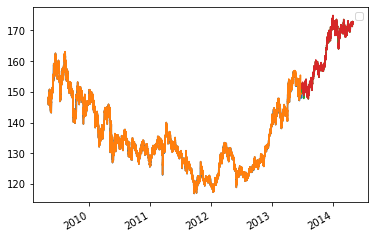

In [6]:
# %matplotlib notebook
%matplotlib inline
print('length: ', len(trn_df), '\n', trn_df.head())
print('length: ', len(tst_df), '\n', tst_df.head())
fig, ax = plt.subplots()
ax.plot(trn_df)
ax.plot(tst_df)
ax.legend()
fig.autofmt_xdate()

In [7]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.mean(axis=1)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.df[idx].to_numpy()

In [8]:
class FixedWindow(torch.utils.data.Dataset):
    def __init__(self, df, window_length):
        self.data = df.mean(axis=1).to_numpy().astype(np.float32)
        self.k = window_length
    def __len__(self):
        return len(self.data) - self.k
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            idx = slice(idx.start+self.k, idx.stop+self.k)
        else:
            idx = idx + self.k
        return self.data[idx - self.k: idx]

In [9]:
from madigan.fleet.conv_model import calc_conv_out_shape 

class AE_MLP(nn.Module):
    """
        Symmetric - number of encoding layers == number of deconding layers
    """
    def __init__(self, input_size, encoded_size, d_model, n_encoding_layers):
        super().__init__()
        self.inp_sz = input_size
        self.enc_dz = encoded_size
        layers = [nn.Linear(input_size, d_model), nn.ReLU()]
        for i in range(n_encoding_layers):
            layers.append(nn.Linear(d_model, d_model))
            layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers, nn.Linear(d_model, encoded_size))
        layers = [nn.Linear(encoded_size, d_model)]
        for i in range(n_encoding_layers):
            layers.append(nn.Linear(d_model, d_model))
            layers.append(nn.ReLU())
        self.decoder = nn.Sequential(*layers, nn.Linear(d_model, input_size))        
        self.act = nn.ReLU()
        
    def forward(self, x):
        norm = x[:, -1][..., None]
        x = x / norm
        encoded = self.encoder(x)
        decoded = self.decoder(self.act(encoded))
        return decoded * norm

In [10]:
from torch.nn.functional import relu, gelu

class AE_CNN_SYMM(nn.Module):
    """
        Symmetric - number of encoding layers == number of deconding layers
    """
    def __init__(self, input_size, encoded_size, d_model, n_encoding_layers, 
                 dropout=0.1):
        super().__init__()
        self.inp_sz = input_size
        self.enc_dz = encoded_size
        self.d_model = d_model
        self.dropout = dropout
        self.act = nn.GELU()
        
        layers = [nn.Conv1d(1, d_model, 5), nn.ReLU()]
        for i in range(n_encoding_layers):
            layers.append(nn.Conv1d(d_model,  d_model, 5))
            layers.append(self.act)
            layers.append(nn.BatchNorm1d(d_model))
            
            
        self.encoder_conv = nn.Sequential(*layers)
        out_shape = calc_conv_out_shape(input_size, layers)[0]
        self.encoder_fc = nn.Linear(out_shape*d_model, encoded_size)
        
        self.decoder_fc = nn.Linear(encoded_size, d_model*(out_shape))
        
        layers = []
        for i in range(n_encoding_layers):
            layers.append(nn.ConvTranspose1d(d_model, d_model, 5))
            layers.append(self.act)
            layers.append(nn.BatchNorm1d(d_model))
        self.decoder_conv = nn.Sequential(*layers, nn.ConvTranspose1d(d_model, 1, 5))
        
        
    def forward(self, x):
        norm = x[:, -1][..., None]
        x = x / norm
        x = x[..., None].transpose(1, -1)
        x = self.encoder_conv(x).reshape(x.shape[0], -1)
        x = self.act(self.encoder_fc(x))
        x = self.act(self.decoder_fc(x))
        x = x.reshape(x.shape[0], self.d_model, -1)
        x = self.decoder_conv(x)[:, 0, :]        
        return x * norm

In [11]:
class AE_CNN_ASYMM(nn.Module):
    """
    Asymmetric - contains fc layers after encoding
    """
    def __init__(self, input_size, encoded_size, d_model, n_encoding_layers):
        super().__init__()
        self.inp_sz = input_size
        self.enc_dz = encoded_size
        self.d_model = d_model
        self.act = nn.GELU()
        
        layers = [nn.Conv1d(1, d_model, 5), nn.ReLU()]
        for i in range(n_encoding_layers):
            layers.append(nn.Conv1d(d_model,  d_model, 5))
            layers.append(self.act)
            layers.append(nn.BatchNorm1d(d_model))
            
        self.encoder_conv = nn.Sequential(*layers)
        out_shape = calc_conv_out_shape(input_size, layers)[0]
        self.encoder_fc = nn.Linear(out_shape*d_model, encoded_size)
        
        layers = [nn.Linear(encoded_size, d_model)]
        for i in range(n_encoding_layers):
            layers.append(nn.Linear(d_model, d_model, 5))
            layers.append(self.act)
            layers.append(nn.BatchNorm1d(d_model))
            
        self.decoder = nn.Sequential(*layers, nn.ConvTranspose1d(d_model, 1, 5))
        
        self.act = nn.GELU()
        
    def forward(self, x):
        norm = x[:, -1][..., None]
        x = x / norm
        x = x[..., None].transpose(1, -1)
        x = self.encoder_conv(x).view(x.shape[0], -1)
        x = self.act(self.encoder_fc(x))
        x = self.act(self.decoder_fc(x))
        x = x.view(x.shape[0], self.d_model, -1)
        x = self.decoder_conv(x)[:, 0, :]        
        return x * norm

In [12]:
def trainer(model, dataloader, device, lr=1e-3):
    loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for i, x in enumerate(iter(dataloader)):
        opt.zero_grad()
        x = x.to(device)
        y = x
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()
        _loss = loss.detach().item()
        yield _loss
        if i % 100 == 0:
            print(_loss, end='\r', flush=True)
        
@torch.no_grad()
def test(model, dataloader, device):
    loss_fn = nn.MSELoss()
    losses = []
    xs = []
    preds = []
    for i, x in enumerate(iter(dataloader)):
        x = x.to(device)
        y = x
        pred = model(x)
        loss = loss_fn(pred, y)
        losses.append(loss.detach().item())
        xs.append(x.cpu().numpy())
        preds.append(pred.cpu().numpy())
    return {'loss': losses, 'x': xs, 'pred': preds}
        

In [13]:
def show_performance(metrics):
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    axs = ax.flatten()
    for i, _ax in enumerate(axs):
        _ax.plot(metrics['x'][0][i], label='x')
        _ax.plot(metrics['pred'][0][i], label='pred')
        _ax.legend()
    return fig, ax


In [14]:
window_size = 64
batch_size = 128

trn_dset = FixedWindow(trn_df, window_size)
tst_dset = FixedWindow(tst_df, window_size)
trnloader = torch.utils.data.DataLoader(trn_dset, batch_size=batch_size, shuffle=True)
tstloader = torch.utils.data.DataLoader(tst_dset, batch_size=batch_size, shuffle=True)

model = AE_CNN_SYMM(input_size=64, encoded_size=32, d_model=32, n_encoding_layers=4).to(device)


In [386]:
# Test forward pass

x = next(iter(trnloader)).to(device)
pred = model(x)

assert x.shape == pred.shape 

In [387]:
losses = []

In [ ]:
epochs = 5

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in tqdm(range(epochs)):
    train_loop = iter(trainer(model, trnloader, device))
    for loss in tqdm(train_loop, total=len(trnloader)):
        losses.append(loss)
    

0.040345828980207441


0.1257844269275665366


0.0322549715638160723


0.059993389993906024


0.147467494010925385


0.036041751503944426


0.127314984798431405


0.074527435004711155


0.057395115494728095


0.074767678976058964


0.064695343375206656


0.046509690582752236


0.039531525224447255


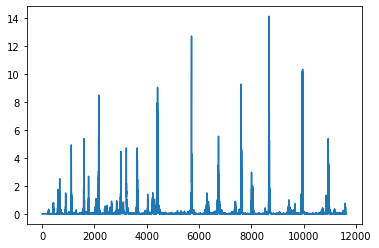

In [390]:
plt.plot(losses[-len(trnloader)+100:])

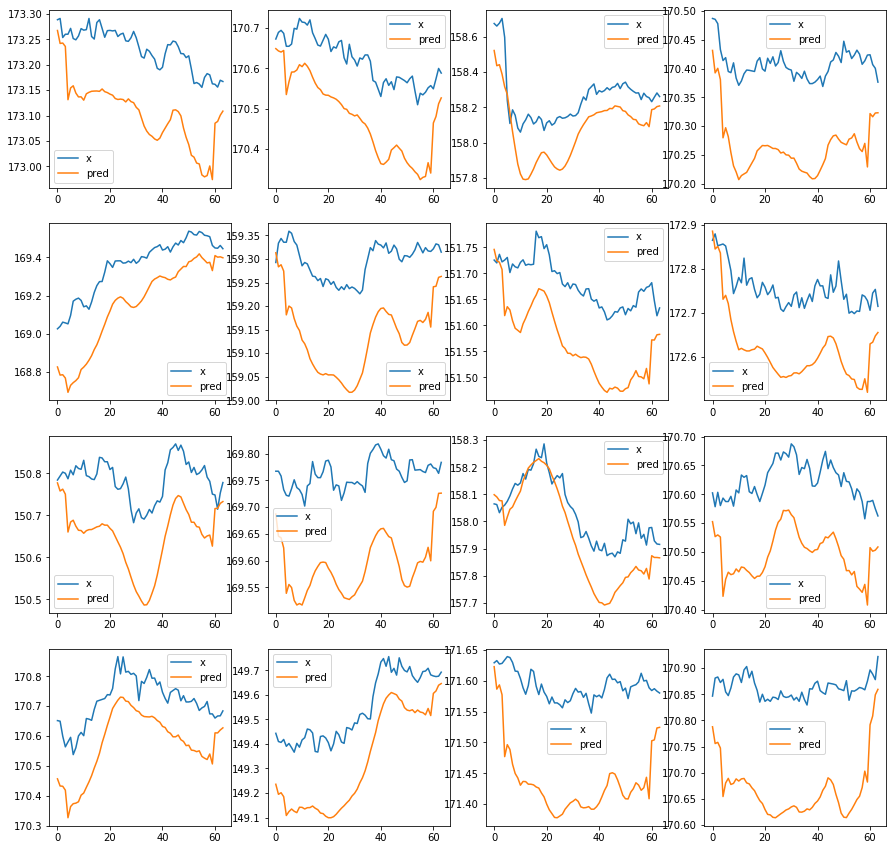

In [391]:
metrics = test(model, tstloader, device)
_ = show_performance(metrics)